# Working with Programs

In Brush, a *Program* is an executable data structure. 
You may think of it as a *model* or a *function* mapping feature inputs to data labels. 
We call them programs because that's what they are: executable data structures,  
and that is what they are called in the genetic algorithm literature, to distinguish them from optimizing bits or strings. 

The Brush Program class operates similarly to a [sklearn](scikit-learn.org) estimator: it has `fit` and `predict` methods that are called in during training or inference, respectively. 


## Types of Programs 

There are four fundamental "types" of Brush programs:

- **Regressors**: map inputs to a continous endpoint 
- **Binary Classifiers**: map inputs to a binary endpoint, as well as a continuous value in $[0, 1]$  
- **Multi-class Classifiers**: map inputs to a category
    - Under development
- **Representors**: map inputs to a lower dimensional space. 
    - Under development

## Representation 

Internally, the programs are represented as syntax trees. 
We use the [tree.hh tree class](https://github.com/kpeeters/tree.hh) which gives trees an STL-like feel. 



## Generation

We generate random programs using Sean Luke's PTC2 algorithm.  


## Evaluation

TODO




## Visualizing Programs

Programs in Brush are symbolic tree structures, and can be viewed in a few ways: 


1. As a string using `get_model()`
2. As a string-like tree using `get_model("tree")`
2. As a graph using `graphviz` and `get_model("dot")`. 

Let's look at a regresion example.

In [1]:
import pandas as pd
from pybrush import BrushRegressor

# load data
df = pd.read_csv('../examples/datasets/d_enc.csv')
X = df.drop(columns='label')
y = df['label']

In [2]:
# import and make a regressor
est = BrushRegressor(
    functions=['SplitBest','Add','Mul','Sin','Cos','Exp','Logabs'],
    verbosity=1 # set verbosity==1 to see a progress bar
)

# use like you would a sklearn regressor
est.fit(X,y)
y_pred = est.predict(X)
print('score:', est.score(X,y))

Completed 100% [====================]
saving final population as archive...
score: 0.8864496494920485


You can see the fitness of the final individual by accessing the `fitness` attribute. Each fitness value corresponds to the objective of same index defined earlier for the `BrushRegressor` class. By default, it will try to minimize `"error"` and `"size"`.

In [3]:
print(est.best_estimator_.fitness)
print(est.objectives)

Fitness(10.263265 19.000000 )
['scorer', 'size']


A `fitness` in Brush is actually more than a tuple. It is a class that has all boolean comparison operators overloaded to allow an ease of use when prototyping with Brush.

It also infers the weight of each objective to automatically handle minimization or maximization objetives.

To see the weights, you can try:

In [4]:
est.best_estimator_.fitness.weights

[-1.0, -1.0]

Other information of the best estimator can also be accessed through its fitness attribute:

In [5]:
print(est.best_estimator_.fitness.size)
print(est.best_estimator_.fitness.complexity)
print(est.best_estimator_.fitness.depth)

19
6088
3


## Serialization 

Brush let's you serialize the entire individual, or just the program or fitness it wraps. It uses JSON to serialize the objects, and this is implemented with the get and set states of an object:

In [6]:
estimator_dict = est.best_estimator_.__getstate__()

for k, v in estimator_dict.items():
    print(k, v)

fitness {'complexity': 6088, 'crowding_dist': 3.4028234663852886e+38, 'dcounter': 0, 'depth': 3, 'dominated': [125, 127, 176, 188], 'linear_complexity': 40, 'loss': 10.263264656066895, 'loss_v': 10.263264656066895, 'rank': 1, 'size': 19, 'values': [10.263264656066895, 19.0], 'weights': [-1.0, -1.0], 'wvalues': [-10.263264656066895, -19.0]}
id 259
is_fitted_ False
objectives ['mse', 'size']
parent_id [282]
program {'Tree': [{'W': 0.75, 'arg_types': ['ArrayF', 'ArrayF'], 'center_op': False, 'feature': 'x0', 'fixed': False, 'is_weighted': True, 'name': 'SplitBest', 'node_type': 'SplitBest', 'prob_change': 1.0, 'ret_type': 'ArrayF', 'sig_dual_hash': 9996486434638833164, 'sig_hash': 10001460114883919497}, {'W': 0.8050000071525574, 'arg_types': ['ArrayF', 'ArrayF'], 'center_op': False, 'feature': 'x0', 'fixed': False, 'is_weighted': True, 'name': 'SplitBest', 'node_type': 'SplitBest', 'prob_change': 1.0, 'ret_type': 'ArrayF', 'sig_dual_hash': 9996486434638833164, 'sig_hash': 1000146011488391

With serialization, you can use pickle to save and load just programs or even the entire individual.

In [7]:
import pickle
import os, tempfile

individual_file = os.path.join(tempfile.mkdtemp(), 'individual.json')
with open(individual_file, "wb") as f:
    pickle.dump(est.best_estimator_, f)

program_file = os.path.join(tempfile.mkdtemp(), 'program.json')
with open(program_file, "wb") as f:
    pickle.dump(est.best_estimator_.program, f)

Then we can load it later with:

In [8]:
with open(individual_file, "rb") as f:
    loaded_estimator = pickle.load(f)
    print(loaded_estimator.get_model())

If(x0>0.75,If(x0>0.81,30.49,49.48*x0),0.02*x1)


### String

Now that we have trained a model, `est.best_estimator_` contains our symbolic model. 
We can view it as a string:

In [9]:
print(est.best_estimator_.get_model())

If(x0>0.75,If(x0>0.81,30.49,49.48*x0),0.02*x1)


### Quick Little Tree

Or, we can view it as a compact tree:

In [10]:
print(est.best_estimator_.get_model("tree"))

If(x0)
|- If(x0)
|  |- 30.49
|  |- 49.48*x0
|- 0.02*x1


### GraphViz

If we are feeling fancy 🎩, we can also view it as a graph in dot format. 
Let's import graphviz and make a nicer plot.

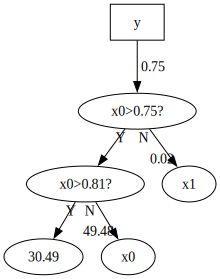

In [11]:
import graphviz

model = est.best_estimator_.get_model("dot")
graphviz.Source(model)

The `model` variable is now a little program in the [dot language](https://graphviz.org/docs/layouts/dot/), which we can inspect directly. 

In [12]:
print(model)

digraph G {
y [shape=box];
y -> "7f2110142b30" [label="0.75"];
"7f2110142b30" [label="x0>0.75?"];
"7f2110142b30" -> "7f211016c9e0" [headlabel="",taillabel="Y"];
"7f2110142b30" -> "x1" [headlabel="0.02",taillabel="N"];
"7f211016c9e0" [label="x0>0.81?"];
"7f211016c9e0" -> "7f2110142520" [headlabel="",taillabel="Y"];
"7f211016c9e0" -> "x0" [headlabel="49.48",taillabel="N"];
"7f2110142520" [label="30.49"];
"x0" [label="x0"];
"x1" [label="x1"];
}



### Tweaking Graphs

The [dot manual](https://graphviz.org/docs/layouts/dot/) has lots of options for tweaking the graphs. 
You can do this by manually editing `model`, but brush also provides a function, `get_dot_model()`, to which you can pass additional arguments to dot. 

For example, let's view the graph from Left-to-Right: 

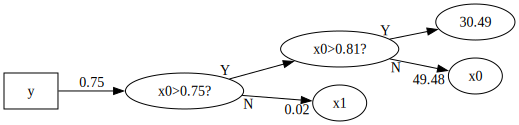

In [13]:
model = est.best_estimator_.get_dot_model("rankdir=LR;")
graphviz.Source(model)

### A classification example

Completed 100% [====================]
saving final population as archive...
Best model: Logistic(Sum(-0.62,If(AIDS>0.41,9.13,-0.70*Total)))
score: 0.68


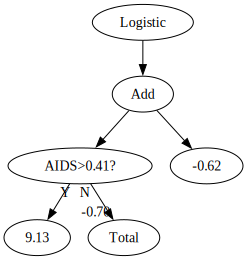

In [14]:
from pybrush import BrushClassifier
from sklearn.preprocessing import StandardScaler

# load data
df = pd.read_csv('../examples/datasets/d_analcatdata_aids.csv')
X = df.drop(columns='target')
y = df['target']

if True:
    scl = StandardScaler().fit(X)
    X = pd.DataFrame(scl.transform(X), columns=X.columns)

est = BrushClassifier(
    functions=['SplitOn', 'SplitBest', 'Sin','Cos','Exp'],
    max_gens=100,
    objectives=["scorer", "linear_complexity"],  
    scorer="log",
    pop_size=100,
    bandit='dynamic_thompson',
    verbosity=1
)

est.fit(X,y)

print("Best model:", est.best_estimator_.get_model())
print('score:', est.score(X,y))

model = est.best_estimator_.get_dot_model()
graphviz.Source(model)